In [2]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
# import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier

import optuna

In [3]:
import numpy as np
import pandas as pd 

In [111]:
train = pd.read_csv("C:\\Users\\DELL\\Downloads\\train_kaggle.csv\\train.csv")
test = pd.read_csv("C:\\Users\\DELL\\Downloads\\test_kaggle.csv\\test.csv")
submission = pd.read_csv("C:\\Users\\DELL\\Downloads\\sample_submission.csv")

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (19219, 35)
The dimension of the test dataset is: (12814, 28)


In [112]:
train.duplicated().sum()

0

In [113]:
target_cols = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
train_cols = [column for column in train.columns if column not in target_cols + ["id"]]

In [114]:
def make_new_features(df):
    epsilon = 1e-5
    cols_before = list(df.columns)
    
    # Calculate new features
    df["X_Max_Len"] = np.abs(df["X_Maximum"] - df["X_Minimum"])
    df["Y_Max_Len"] = np.abs(df["Y_Maximum"] - df["Y_Minimum"])
    df["Xmax_Ymax_diff"] = np.abs((df["X_Maximum"] - df["Y_Maximum"]) / (df["X_Maximum"] + epsilon))
    df["Xmin_Ymin_diff"] = np.abs((df["X_Minimum"] - df["Y_Minimum"]) / (df["X_Minimum"] + epsilon))
    df["X_Y_Max_Diff"] = np.abs((df["X_Maximum"] - df["Y_Minimum"]) / (df["X_Maximum"] + epsilon))
    df["Y_X_Max_Diff"] = np.abs((df["Y_Maximum"] - df["X_Minimum"]) / (df["Y_Maximum"] + epsilon))
    df["Max_Area"] = np.abs(df["X_Max_Len"] * df["Y_Max_Len"])
    df["Max_Pixel_Density"] = df["Max_Area"] / (df["Pixels_Areas"] + epsilon)
    df["Perimeter_Ratio"] = np.abs(df["X_Perimeter"] / (df["Y_Perimeter"] + epsilon))
    df["Sum_Of_Indices"] = df[[col for col in df.columns if col.endswith("_Index")]].sum(axis=1)
    df["Product_X_Y_Edge_Indices"] = df["Edges_X_Index"] * df["Edges_Y_Index"]
    df["Sum_X_Y_Edge_Indices"] = df["Edges_X_Index"] + df["Edges_Y_Index"]
    df["Product_X_Y_Indices"] = df["Log_X_Index"] * df["Log_Y_Index"]
    df["Sum_X_Y_Indices"] = df["Log_X_Index"] + df["Log_Y_Index"]
    
    cols_after = list(df.columns)
    new_features = [feat for feat in cols_after if feat not in cols_before]
    
    return new_features

if not set(make_new_features(train)).issubset(set(train.columns)):
    new_features_train = make_new_features(train)
    train = pd.concat([train, new_features_train], axis=1)

if not set(make_new_features(test)).issubset(set(test.columns)):
    new_features_test = make_new_features(test)
    test = pd.concat([test, new_features_test], axis=1)


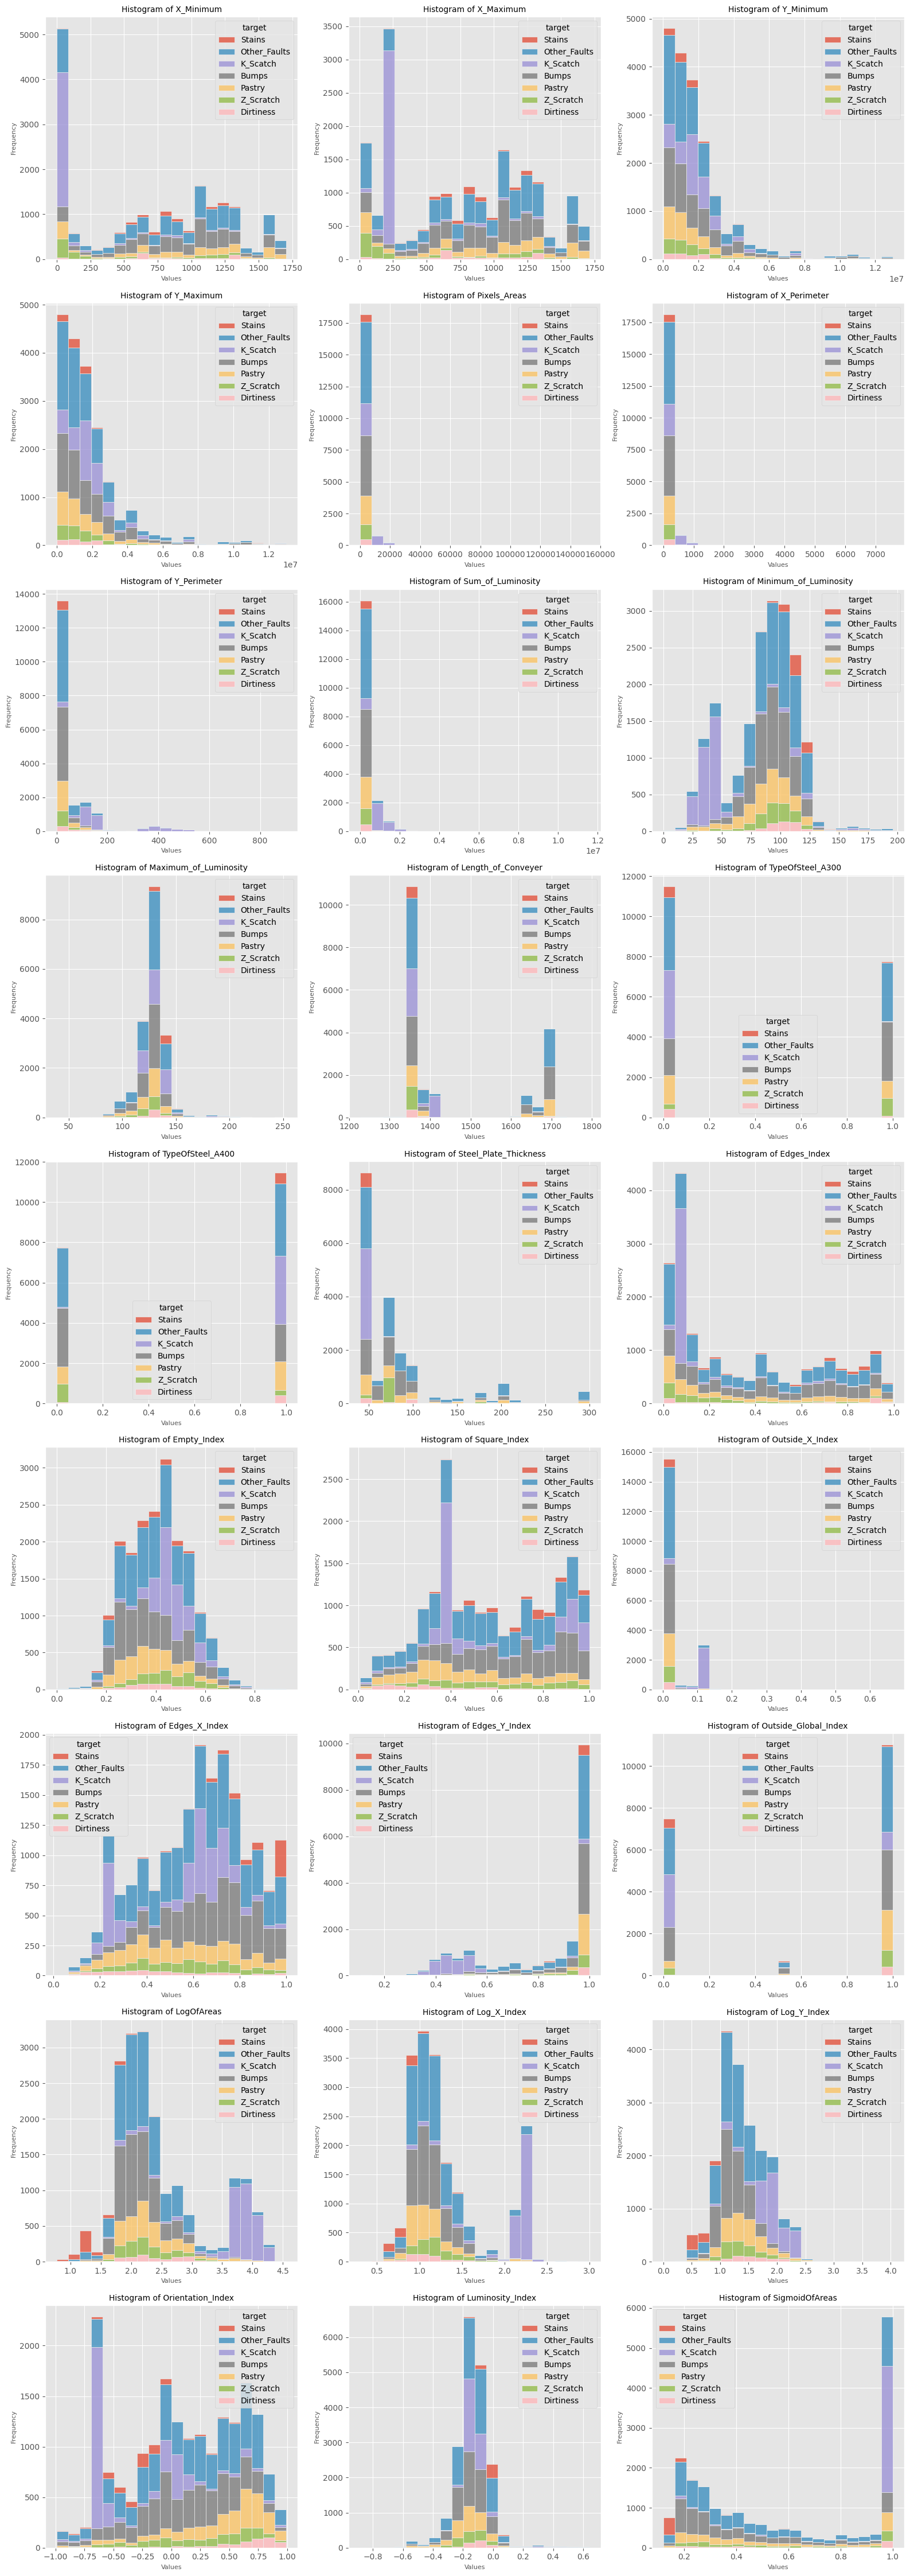

In [115]:
def plot_stacked_histogram(df, columns, target_column, n_cols=3, row_height=5, log_scale=False):
    n_rows = (len(columns) + 1) // n_cols

    if n_rows == 0:
        n_rows = 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*row_height))
    
  
    if n_rows > 1:
        axes = axes.flatten()

    for i, column in enumerate(columns):
     
        sns.histplot(df, x=column, bins=20, multiple='stack', hue=target_column, ax=axes[i], log_scale=log_scale, color='skyblue')

        axes[i].set_title(f'Histogram of {column}', fontsize=10)
        axes[i].set_xlabel('Values', fontsize=8)
        axes[i].set_ylabel('Frequency', fontsize=8)

    plt.tight_layout()
    plt.show()

train["target"] = train[target_cols].idxmax(axis=1)

plot_stacked_histogram(train, train_cols, "target")

In [116]:
train.drop(columns=['id'],axis=1,inplace=True)

In [117]:
test.drop(columns=['id'],axis=1,inplace=True)

In [118]:
train.drop(columns=target_cols,axis=1,inplace=True)

In [119]:

    
label_encoder = LabelEncoder()
train['target']= label_encoder.fit_transform(train['target'])



In [120]:
train.to_csv('trainf2.csv', index=False)
test.to_csv('testf2.csv',index=False)
# y_train.to_csv('y_train_finall.csv',index=False)

In [121]:
cat_feats = [x for x in train.columns if len(train[x].unique()) <=10]
num_feats = [x for x in train.columns if x not in cat_feats]

In [122]:
skew_threshold = 0.5  

columns_to_transform = train.columns.difference(cat_feats)

skewness = train[columns_to_transform].apply(lambda x: x.skew())

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
function_transformer = FunctionTransformer(np.log1p, validate=True)  
transformer = ColumnTransformer([
    ('power_transform', power_transformer, skewness[skewness > skew_threshold].index),
    ('log_transform', function_transformer, skewness[skewness <= skew_threshold].index)
])


In [123]:
X_train_transformed = transformer.fit_transform(train)

In [124]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=columns_to_transform)

In [125]:

train_transformed = pd.concat([train[cat_feats], X_train_transformed[columns_to_transform]], axis=1)


In [126]:
cat_feats = [x for x in test.columns if len(test[x].unique()) <=10]
num_feats = [x for x in test.columns if x not in cat_feats]

In [127]:
skew_threshold = 0.5  

columns_to_transform = test.columns.difference(cat_feats)

skewness = test[columns_to_transform].apply(lambda x: x.skew())

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
function_transformer = FunctionTransformer(np.log1p, validate=True)  
transformer = ColumnTransformer([
    ('power_transform', power_transformer, skewness[skewness > skew_threshold].index),
    ('log_transform', function_transformer, skewness[skewness <= skew_threshold].index)
])


In [128]:
X_test_transformed = transformer.fit_transform(test)

In [129]:
X_test_transformed = pd.DataFrame(X_test_transformed, columns=columns_to_transform)

In [130]:

test_transformed = pd.concat([test[cat_feats], X_test_transformed[columns_to_transform]], axis=1)


In [131]:
test_transformed.shape

(12814, 41)

In [132]:
train_transformed.to_csv('trainf3.csv', index=False)
test_transformed.to_csv('testf3.csv',index=False)
# y_train.to_csv('y_train_finall.csv',index=False)

In [133]:
numerical_columns = train_transformed.select_dtypes(include=[np.number]).columns

# Exclude columns with less than a certain number of unique values
threshold_unique_values = 10
categorical_columns = [col for col in numerical_columns if train_transformed[col].nunique() <= threshold_unique_values]

# Remove categorical columns from numerical_columns
numerical_columns = numerical_columns.difference(categorical_columns)


In [134]:
categorical_columns

['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index', 'target']

In [135]:
import numpy as np

def cap_outliers_iqr(data, threshold=1.4):
    q1 = np.percentile(data, 5)
    q3 = np.percentile(data, 95)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    capped_data = np.clip(data, lower_bound, upper_bound)
    return capped_data

# numerical_columns = train.select_dtypes(include=[np.number]).columns
for column in numerical_columns:
    train_transformed[column] = cap_outliers_iqr(train_transformed[column])


In [136]:
train_transformed.shape

(19219, 42)

In [137]:
y_train=train_transformed['target']
X_train=train_transformed.drop(columns=['target'],axis=1)

In [138]:
X_train.to_csv('trainf4.csv', index=False)
test_transformed.to_csv('testf4.csv',index=False)
y_train.to_csv('y_train4.csv',index=False)

In [139]:
X_train=pd.read_csv('trainf4.csv')

In [140]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    
    numeric_cols = X_train.select_dtypes(include=['int', 'float']).columns
   
    vif = pd.DataFrame()
    vif['Feature'] = numeric_cols
    vif['VIF'] = [variance_inflation_factor(X_train[numeric_cols].values, i) for i in range(len(numeric_cols))]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif

vif_results = calc_vif(X_train)



In [141]:
vif_results[:5]

,Feature,VIF
37,Y_Maximum,119597.92
28,Sum_of_Luminosity,53915.97
27,Sum_X_Y_Indices,33308.35
40,Y_X_Max_Diff,11598.19
36,Y_Max_Len,10117.11


In [142]:
X_train.drop(columns=['Y_Maximum'],axis=1,inplace=True)
# test.drop(columns=['Y_Maximum'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
39,Y_X_Max_Diff,9404.41
36,Y_Max_Len,8760.94
30,X_Maximum,3106.57
37,Y_Minimum,2440.26
38,Y_Perimeter,728.08


In [143]:
test_transformed.drop(columns=['Y_Maximum'],axis=1,inplace=True)
test_transformed.drop(columns=['Y_X_Max_Diff'],axis=1,inplace=True)
test_transformed.drop(columns=['Y_Max_Len'],axis=1,inplace=True)

In [144]:
X_train.drop(columns=['Y_X_Max_Diff'],axis=1,inplace=True)
# test.drop(columns=['Y_X_Max_Diff'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
36,Y_Max_Len,6272.61
30,X_Maximum,2650.42
37,Y_Minimum,2315.96
38,Y_Perimeter,727.77
28,Sum_of_Luminosity,620.39


In [145]:
X_train.drop(columns=['Y_Max_Len'],axis=1,inplace=True)
# test.drop(columns=['Y_Max_Len'],axis=1,inplace=True)
calc_vif(X_train)[:5]

,Feature,VIF
36,Y_Minimum,2127.04
30,X_Maximum,1150.18
37,Y_Perimeter,686.34
20,Product_X_Y_Edge_Indices,558.37
21,Product_X_Y_Indices,503.99


In [146]:


correlation_matrix = X_train.corr().abs()
correlated_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:  
            colname = correlation_matrix.columns[i]  
            correlated_features.add(colname)


df_filtered = X_train.drop(columns=correlated_features)

features=df_filtered.columns



print("after correlation",features)
print("correlated features are\t",correlated_features)


after correlation Index(['TypeOfSteel_A300', 'Outside_Global_Index', 'Edges_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Empty_Index', 'Length_of_Conveyer',
       'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Luminosity_Index',
       'Max_Area', 'Minimum_of_Luminosity', 'Perimeter_Ratio', 'Pixels_Areas',
       'Product_X_Y_Edge_Indices', 'SigmoidOfAreas', 'Square_Index',
       'Steel_Plate_Thickness', 'Sum_X_Y_Indices', 'Sum_of_Luminosity',
       'X_Max_Len', 'X_Minimum', 'X_Perimeter', 'X_Y_Max_Diff',
       'Xmax_Ymax_diff', 'Xmin_Ymin_diff', 'Y_Minimum', 'Y_Perimeter'],
      dtype='object')
correlated features are	 {'Maximum_of_Luminosity', 'Product_X_Y_Indices', 'TypeOfSteel_A400', 'Sum_Of_Indices', 'Sum_X_Y_Edge_Indices', 'Max_Pixel_Density', 'X_Maximum', 'Outside_X_Index', 'Orientation_Index'}


In [147]:
correlated_features

{'Max_Pixel_Density',
 'Maximum_of_Luminosity',
 'Orientation_Index',
 'Outside_X_Index',
 'Product_X_Y_Indices',
 'Sum_Of_Indices',
 'Sum_X_Y_Edge_Indices',
 'TypeOfSteel_A400',
 'X_Maximum'}

In [148]:
X_train=X_train[features]

In [149]:

target_feature = 'target'
features_without_target = [feature for feature in features if feature != target_feature]

print(features_without_target)


['TypeOfSteel_A300', 'Outside_Global_Index', 'Edges_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Empty_Index', 'Length_of_Conveyer', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Luminosity_Index', 'Max_Area', 'Minimum_of_Luminosity', 'Perimeter_Ratio', 'Pixels_Areas', 'Product_X_Y_Edge_Indices', 'SigmoidOfAreas', 'Square_Index', 'Steel_Plate_Thickness', 'Sum_X_Y_Indices', 'Sum_of_Luminosity', 'X_Max_Len', 'X_Minimum', 'X_Perimeter', 'X_Y_Max_Diff', 'Xmax_Ymax_diff', 'Xmin_Ymin_diff', 'Y_Minimum', 'Y_Perimeter']


In [150]:
test_transformed=test_transformed[features_without_target]

In [151]:
test_transformed.shape

(12814, 29)

In [152]:
X_train.shape

(19219, 29)

In [153]:
X_train.isnull().sum()

TypeOfSteel_A300            0
Outside_Global_Index        0
Edges_Index                 0
Edges_X_Index               0
Edges_Y_Index               0
Empty_Index                 0
Length_of_Conveyer          0
LogOfAreas                  0
Log_X_Index                 0
Log_Y_Index                 0
Luminosity_Index            0
Max_Area                    0
Minimum_of_Luminosity       0
Perimeter_Ratio             0
Pixels_Areas                0
Product_X_Y_Edge_Indices    0
SigmoidOfAreas              0
Square_Index                0
Steel_Plate_Thickness       0
Sum_X_Y_Indices             0
Sum_of_Luminosity           0
X_Max_Len                   0
X_Minimum                   0
X_Perimeter                 0
X_Y_Max_Diff                0
Xmax_Ymax_diff              0
Xmin_Ymin_diff              0
Y_Minimum                   0
Y_Perimeter                 0
dtype: int64

In [154]:
test_transformed.isnull().sum()

TypeOfSteel_A300            0
Outside_Global_Index        0
Edges_Index                 0
Edges_X_Index               0
Edges_Y_Index               0
Empty_Index                 0
Length_of_Conveyer          0
LogOfAreas                  0
Log_X_Index                 0
Log_Y_Index                 0
Luminosity_Index            0
Max_Area                    0
Minimum_of_Luminosity       0
Perimeter_Ratio             0
Pixels_Areas                0
Product_X_Y_Edge_Indices    0
SigmoidOfAreas              0
Square_Index                0
Steel_Plate_Thickness       0
Sum_X_Y_Indices             0
Sum_of_Luminosity           0
X_Max_Len                   0
X_Minimum                   0
X_Perimeter                 0
X_Y_Max_Diff                0
Xmax_Ymax_diff              0
Xmin_Ymin_diff              0
Y_Minimum                   0
Y_Perimeter                 0
dtype: int64

In [155]:
# X_train.to_csv('trainf6.csv', index=False)
# test_transformed.to_csv('testf6.csv',index=False)
# # y_train.to_csv('y_train6.csv',index=False)

In [156]:
# X_train=pd.read_csv('trainf6.csv')
# # y_train=pd.read_csv('y_train6.csv')

In [157]:
X_train.shape

(19219, 29)

In [162]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TypeOfSteel_A300          19219 non-null  int64  
 1   Outside_Global_Index      19219 non-null  float64
 2   Edges_Index               19219 non-null  float64
 3   Edges_X_Index             19219 non-null  float64
 4   Edges_Y_Index             19219 non-null  float64
 5   Empty_Index               19219 non-null  float64
 6   Length_of_Conveyer        19219 non-null  float64
 7   LogOfAreas                19219 non-null  float64
 8   Log_X_Index               19219 non-null  float64
 9   Log_Y_Index               19219 non-null  float64
 10  Luminosity_Index          19219 non-null  float64
 11  Max_Area                  19219 non-null  float64
 12  Minimum_of_Luminosity     19219 non-null  float64
 13  Perimeter_Ratio           19219 non-null  float64
 14  Pixels

In [158]:
y_train.shape

(19219,)

In [165]:
y_train=pd.Series(y_train)


In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import numpy as np

rf_clf = RandomForestClassifier(class_weight='balanced')
log_reg_clf = LogisticRegression(class_weight='balanced')
xgb_clf = XGBClassifier()
catboost_clf = CatBoostClassifier()

clf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampling', smote_tomek),  
    ('undersampling', tomek_links),  
    ('classifier', VotingClassifier(estimators=[
        ('rf', rf_clf),
        ('log_reg', log_reg_clf),
        ('xgb', xgb_clf),
        ('catboost', catboost_clf)
    ], voting='soft'))
])

param_distributions = {
    'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), SimpleImputer(strategy='median'), KNNImputer(n_neighbors=5), IterativeImputer(max_iter=10, random_state=0)],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'classifier__rf__max_depth': [3, 5, 10, None],
    'classifier__rf__min_samples_split': randint(2, 20),
    'classifier__rf__class_weight': ['balanced', 'balanced_subsample', None],
    'classifier__log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__xgb__max_depth': [3, 5, 7],
    'classifier__xgb__learning_rate': [0.01, 0.1, 0.3],
    'classifier__xgb__n_estimators': [100, 500, 1000],
    'classifier__xgb__gamma': [0, 0.1, 0.3, 0.5],
    'classifier__xgb__subsample': [0.8, 0.9, 1.0],
    'classifier__catboost__iterations': [100, 500, 1000],
    'classifier__catboost__depth': [4, 6, 8],
    'classifier__catboost__learning_rate': [0.01, 0.1, 0.3],
    'classifier__catboost__l2_leaf_reg': [1, 3, 5, 7, 9]
}

grid_search = RandomizedSearchCV(clf, param_distributions, n_iter=50, cv=10, scoring='accuracy', random_state=42)
grid_search.fit(train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
